<a href="https://colab.research.google.com/github/mangsshinde/auto_img_capt/blob/master/17082022_17_00_Xception_Image_Caption_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# !pip install tensorflow==2.8

In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
# !pip install tensorflow-gpu==2.2.0

In [ ]:
# !pip uninstall keras

In [ ]:
# !pip install tensorflow --upgrade --force-reinstall

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from os import listdir
from collections import Counter


# Loading dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Flickr8k_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._34295

In [4]:
!unzip /content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Flickr8k_text.zip

Archive:  /content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


# Load Captions

In [5]:
def load_doc(filename):
    with open(filename) as file:
        text = file.readlines()
        return text

filename = "/content/Flickr8k.token.txt"
text = load_doc(filename)
for line in text[:10]:
    print(line,end='')

# every image has 5 captions

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


# Mapping image with captions

In [6]:
def image_to_captions(text):
    hash_map = {}
    for line in text:
        token = line.split()
        image_id = token[0].split('.')[0] # separating with '.' to extract image id (removing .jpg)
        image_caption = ' '.join(token[1: ])
        
        if(image_id not in hash_map):
            hash_map[image_id] = [image_caption]
        else:
            hash_map[image_id].append(image_caption)
        
    return hash_map
        

map_img_to_captions = image_to_captions(text)
print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


# Data Preprocessing

In [7]:
def preprocess(map_img_to_captions):
    preprocessed_captions = []
    for key in map_img_to_captions.keys():
        for idx in range(len(map_img_to_captions[key])):
            tokens = map_img_to_captions[key][idx].split()
            tokens = [token.lower() for token in tokens if len(token)>1 if token.isalpha()]
            map_img_to_captions[key][idx] = ' '.join(tokens)
            
    return map_img_to_captions


preprocessed_map = preprocess(map_img_to_captions)
preprocessed_map['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

# Create vocabulary from captions

In [8]:
def create_vocabulary(preprocessed_map):
    vocabulary = set()
    for img_captions in preprocessed_map.values(): # list of 5 captions for each image
        for caption in img_captions:
            for token in caption.split():
                vocabulary.add(token)    
    return vocabulary


vocabulary = create_vocabulary(preprocessed_map)
print('Vocabulary size',len(vocabulary))

Vocabulary size 8357


# Saving image id and preprocessed captions to new text file

In [9]:
def save_captions(preprocessed_map,filename):
    data = []
    for image_id,image_captions in preprocessed_map.items():
        for caption in image_captions:
            data.append(image_id + ' ' + caption + '\n')
            
    with open(filename,'w') as file:
        for line in data:
            file.write(line)

save_captions(preprocessed_map,'preprocessed_captions.txt')

# Load images (image name) of Train & Test Data

In [10]:
def img_id_train(filename):
    with open(filename) as file:
        data = file.readlines()
        train_img_name = []
        for img_id in data:
            train_img_name.append(img_id.split('.')[0])
    return train_img_name    

train_img_name = img_id_train('/content/Flickr_8k.trainImages.txt')
test_img_name  = img_id_train('/content/Flickr_8k.testImages.txt')
print(*train_img_name[:5],sep='\n')
print('\nNumber of images in train data',len(train_img_name))
print('\nNumber of images in train data',len(test_img_name))

2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87

Number of images in train data 6000

Number of images in train data 1000


In [11]:
train_img_name[0]

'2513260012_03d33305cf'

# Load pre-processed captions for Train data (add 'startseq' & 'endseq')

In [12]:
def load_captions_train(filename):
    doc = load_doc(filename) 
    train_captions = {}    
    
    for line in doc:
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]

        if(image_id in train_img_name):
            if(image_id not in train_captions):
                train_captions[image_id] = []
            
            modified_caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            train_captions[image_id].append(modified_caption)
    
    return train_captions


train_captions = load_captions_train('preprocessed_captions.txt')
print(*train_captions['1000268201_693b08cb0e'],sep='\n')

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [13]:
def preprocess_image(img_path):
    img = image.load_img(img_path,target_size=(299,299)) 
    # type(img): PIL.Image.Image
#     plt.figure(figsize=(12,6))
#     plt.subplot(121)
#     plt.imshow(img)
#     plt.title('Original Image(Resized)')

    img = image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
    img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
    img = preprocess_input(img) # preprocess image as per Inception-V3 model
#     plt.subplot(122)
#     plt.imshow(img[0])
#     plt.title('Preprocessed image for Inception-V3')    
    
    return img  # shape: (1, 299, 299, 3)

In [ ]:
# img = preprocess_image('/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
# Image.open('/content/Flicker8k_Dataset/preprocessed_image.PNG')

In [14]:
# Load Inception-V3 model
model = Xception(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)

# model.layers            list of layers
# model.input             <tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>
# model.layers[-1].output <tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32> 1000 target classes
# model.layers[-2].output <tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

91897856/91884032 [==============================] - 0s 0us/step


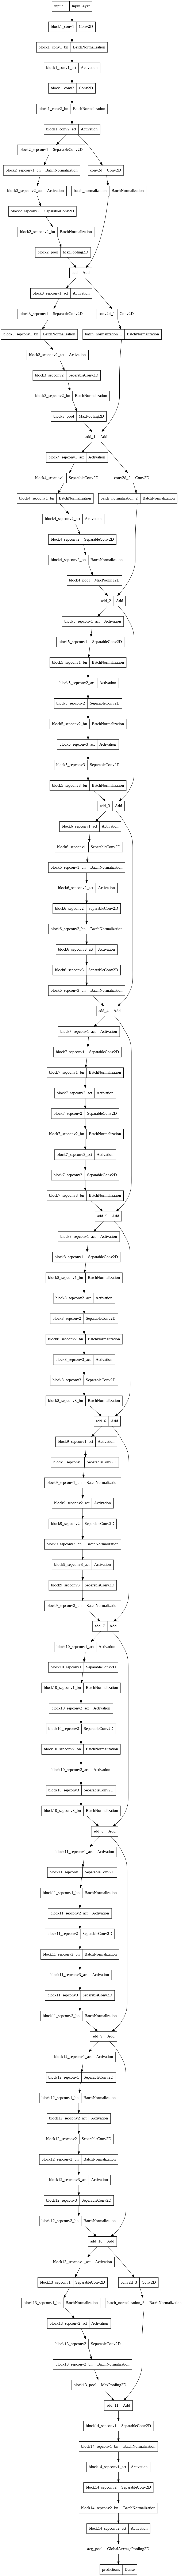

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# model_new.predict(img).shape

(1, 2048)

# All images names

In [16]:
def images_name(path):
    img_name = set([path+image for image in listdir(path)])
    return img_name

path = '/content/Flicker8k_Dataset'
all_images_name = images_name(path)
train_img_name = [path+'/'+img+'.jpg' for img in train_img_name]
test_img_name = [path+'/'+img+'.jpg' for img in test_img_name]

In [17]:
train_img_name

['/content/Flicker8k_Dataset/2513260012_03d33305cf.jpg',
 '/content/Flicker8k_Dataset/2903617548_d3e38d7f88.jpg',
 '/content/Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg',
 '/content/Flicker8k_Dataset/488416045_1c6d903fe0.jpg',
 '/content/Flicker8k_Dataset/2644326817_8f45080b87.jpg',
 '/content/Flicker8k_Dataset/218342358_1755a9cce1.jpg',
 '/content/Flicker8k_Dataset/2501968935_02f2cd8079.jpg',
 '/content/Flicker8k_Dataset/2699342860_5288e203ea.jpg',
 '/content/Flicker8k_Dataset/2638369467_8fc251595b.jpg',
 '/content/Flicker8k_Dataset/2926786902_815a99a154.jpg',
 '/content/Flicker8k_Dataset/2851304910_b5721199bc.jpg',
 '/content/Flicker8k_Dataset/3423802527_94bd2b23b0.jpg',
 '/content/Flicker8k_Dataset/3356369156_074750c6cc.jpg',
 '/content/Flicker8k_Dataset/2294598473_40637b5c04.jpg',
 '/content/Flicker8k_Dataset/1191338263_a4fa073154.jpg',
 '/content/Flicker8k_Dataset/2380765956_6313d8cae3.jpg',
 '/content/Flicker8k_Dataset/3197891333_b1b0fd1702.jpg',
 '/content/Flicker8k_Dataset/3119

# Encode images into feature vectors

In [18]:
# Function to encode given image into a vector of size (2048, )
def encode_image(image):
    image = preprocess_image(image) # preprocess image
    feature_vector = model_new.predict(image) # Get encoding vector for image
    feature_vector = feature_vector.reshape(feature_vector.shape[1], ) # reshape from (1, 2048) to (2048, )
    return feature_vector


# To encode all train images
start_train = time()
encoding_train = {}
for idx,img in enumerate(train_img_name):
    if( (idx+1)%500 == 0):
        print('Train images encoded ',idx+1)
    encoding_train[img] = encode_image(img)
print("** Time taken for encoding train images {} seconds **".format(time()-start_train))


# To encode all test images
start_test = time()
encoding_test = {}
for idx,img in enumerate(test_img_name):
    if( (idx+1)%200 == 0):
        print('Test images encoded ',idx+1)
    encoding_test[img] = encode_image(img)
print("** Time taken for encoding test images {} seconds **".format(time()-start_test))

Train images encoded  500
Train images encoded  1000
Train images encoded  1500
Train images encoded  2000
Train images encoded  2500
Train images encoded  3000
Train images encoded  3500
Train images encoded  4000
Train images encoded  4500
Train images encoded  5000
Train images encoded  5500
Train images encoded  6000
** Time taken for encoding train images 389.7873148918152 seconds **
Test images encoded  200
Test images encoded  400
Test images encoded  600
Test images encoded  800
Test images encoded  1000
** Time taken for encoding test images 63.59550356864929 seconds **


# Save the learned features 

In [19]:
# # Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)
    
# # Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

# All train captions (6000 x 5 = 30,000)

In [20]:
train_features = load(open("encoded_train_images.pkl", "rb"))

# Create a list of all the training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)
    
print(len(all_train_captions))
print(*all_train_captions[:10],sep='\n')

30000
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq black dog and spotted dog are fighting endseq
startseq black dog and dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


# Consider only those words which occur atleast 10 times in corpus

In [21]:
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
    if(count>=10):
        vocab.append(token)
        
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

Number of original tokens 7265
Number of tokens after threshold 1643


# Mapping: Index to words & Word to index

In [22]:
word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))


1643


# Calculate max-length caption

In [23]:
def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption=  33


# Data Preparation using Generator Function

In [24]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            temp='/content/Flicker8k_Dataset'
            
            photo = photos[temp+'/'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# Load GloVe vectors

In [25]:
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(1644, 200)

In [27]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length_caption,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 200)      328800      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

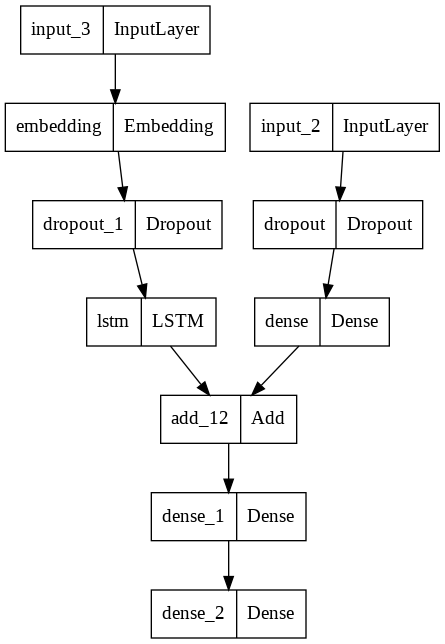

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [29]:
print(model.layers[2])

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
epochs = 20
number_pics_per_bath = 3
steps = len(train_captions)//number_pics_per_bath

In [32]:
len(train_captions)

6000

In [33]:
temp='/content/Flicker8k_Dataset'
temp

'/content/Flicker8k_Dataset'

In [34]:
for i in range(epochs):
    generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Xception_models/model_' + str(i) + '.h5')
# Image.open('training_1.PNG')

2000/2000 [==============================] - 183s 92ms/step - loss: 2.4061


In [ ]:
# import shutil
# shutil.copy("/content/model_weights/model_9.h5", "/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/model_9.h5")

'/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/model_9.h5'

In [ ]:
# shutil.copy('/content/preprocessed_captions.txt','/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/preprocessed_captions.txt')
# shutil.copy('/content/encoded_train_images.pkl','/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/encoded_train_images.pkl')

'/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/encoded_train_images.pkl'

In [ ]:
# shutil.copy('/content/Flickr_8k.trainImages.txt','/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Flickr_8k.trainImages.txt')

'/content/drive/MyDrive/HTCGlobalServices/AutomaticImageCaptioning/Image_cap_ten/Flickr_8k.trainImages.txt'

In [ ]:
# for i in range(epochs):
#     generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('./model_weights/model_' + str(i) + '.h5')
# Image.open('training_2.PNG')  

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_captions)//number_pics_per_bath

# for i in range(epochs):
#     generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     #model.save('./model_weights/model_' + str(i) + '.h5')

Image.open('training_3.PNG')

In [ ]:
# model.save_weights('./model_weights/model_30.h5')
# model.load_weights('./model_weights/model_30.h5')

images = ''
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
    
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length_caption):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length_caption)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

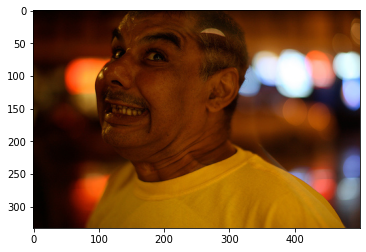

Greedy: man in black shirt and leather cap is wearing black shirt


In [ ]:
z=11
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

# Image.open('inference.PNG')

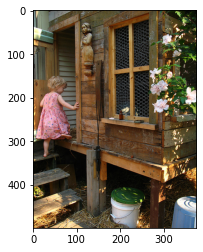

Greedy: man in black shirt and leather cap is wearing black shirt


In [ ]:
x=plt.imread('/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
# if __name__=='__main__':
    
#     # load all captions 
#     text = load_doc("Flickr8k_text/Flickr8k.token.txt") # list
#     for line in text[:10]:
#         print(line,end='')
    
#     # map image to captions in dictionary 
#     map_img_to_captions = image_to_captions(text) # dictionary (key:img name) (value-list of 5 captions)
#     print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')
    
#     # preprocess captions
#     preprocessed_map = preprocess(map_img_to_captions) # dictionary (key:img name) (value-list of 5 preprocessed-captions)
#     print(preprocessed_map['1000268201_693b08cb0e'])

#     # prepare vocabulary from captions
#     vocabulary = create_vocabulary(preprocessed_map) # list
#     print('Vocabulary size',len(vocabulary))
    
#     # save image name with preprocessed captions in a new text file
#     filename = 'preprocessed_captions.txt'
#     save_captions(preprocessed_map,filename)
#     print('Saved image names with preprocessed captions in {}'.format(filename))
    
    
#     # load image name for train & test data
#     train_img_name = img_id_train('Flickr8k_text/Flickr_8k.trainImages.txt') # list
#     test_img_name  = img_id_train('Flickr8k_text/Flickr_8k.testImages.txt')  # list 
#     print('\nNumber of images in train data',len(train_img_name)) 
#     print('\nNumber of images in train data',len(test_img_name))
    
#     # load captions for train data and 'start_seq' and 'end_seq' in starting and end of each caption respectively
#     train_captions = load_captions_train('preprocessed_captions.txt')
#     print(*train_captions['1000268201_693b08cb0e'],sep='\n')
    
    
#     # image names for complete, train and test data
#     path = 'Flickr8k_Dataset/Flicker8k_Dataset/'
#     all_images_name = images_name(path)
#     train_img_name = [path+img+'.jpg' for img in train_img_name]
#     test_img_name = [path+img+'.jpg' for img in test_img_name]
    
    
#     # Load Inception-V3 model
#     model = InceptionV3(weights='imagenet')
#     # Create new model, by removing last layer (output layer) from Inception-V3
#     model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)
    
    
# #     # encode all train images
# #     start_train = time()
# #     encoding_train = {}
# #     for idx,img in enumerate(train_img_name):
# #         if( (idx+1)%500 == 0):
# #             print('Train images encoded ',idx+1)
# #         encoding_train[img] = encode_image(img)
# #     print("** Time taken for encoding train images {} seconds **".format(time()-start_train))


# #     # encode all test images
# #     start_test = time()
# #     encoding_test = {}
# #     for idx,img in enumerate(test_img_name):
# #         if( (idx+1)%200 == 0):
# #             print('Test images encoded ',idx+1)
# #         encoding_test[img] = encode_image(img)
# #     print("** Time taken for encoding test images {} seconds **".format(time()-start_test))
    
    
# # Save the bottleneck train features to disk
# #     with open("encoded_train_images.pkl", "wb") as encoded_pickle:
# #         dump(encoding_train, encoded_pickle)

# # Save the bottleneck test features to disk
# #     with open("encoded_test_images.pkl", "wb") as encoded_pickle:
# #         dump(encoding_test, encoded_pickle)


    